# **NDSI with MODIS and Dask**

This tutorial notebook demonstrates how to find, visualize, and analyze the Normalized Difference Snow Index with MODIS imagery, efficiently using Dask. The satellite we will be using is the MODIS Terra Surface Reflectance 8-day Global 500m Version 6 (MOD09GA.006).

**What is NDSI?**

The Normalized Difference Snow Index is used to detect the presence of snow in a pixel. Identifying snow cover is important for hazard mitigation, and for hydrological and weather forecasting. Snow has very high visible (Green) reflectance and very low reflectance in the shortwave infrared (SWIR), which makes it easy to differentiate snow cover from most cloud types. 

**How is NDSI calculated?**

To calculate NDSI, the Visible Green light band and SWIR band are used in this formula: 

- **`NDSI = (Green - SWIR) / (Green + SWIR)`**

In MOD09GA Version 6, Band 4 is green and Band 6 is SWIR. 

**What do NDSI values represent?**

The NDSI values ranging from 0 to 1, higher values (NDSI > 0.4) represent snow. The MODIS products were tested with different NDSI thresholds ranging from 0.3 to 0.4 to map the snow cover over low-altitude glaciers due to its coarser resolution.



## 1. Initialize your Dask Gateway Clusters
Since we want to use eight years of data for our analysis, running the computation using the cores of the machine we are running this notebook on is not ideal. Let's connect to Dask Gateway so the clusters can run our work on Elastic Compute Cloud (EC2) machines.

For now, we will set our cluster to scale the workers to 20, because of the amount of data we will be working with.

In [1]:
!pip install planetary_computer

In [2]:
import os
import glob
import re
import datetime
import requests
import sys
import time
import io
import math
import yaml
import tempfile
import stackstac
import planetary_computer

import dask
import distributed
import rasterio

import pandas as pd
import xarray as xr
import numpy as np
import rioxarray as rxr
import geopandas as gpd

from dask.distributed import wait, progress
from IPython.display import clear_output
from rasterio.plot import show
from urllib.request import urlopen, Request, build_opener, HTTPCookieProcessor
from dask_gateway import Gateway
from shapely.geometry import Polygon
from pystac_client import Client

In [3]:
gateway = Gateway()
cluster = gateway.connect('daskhub.de59c56b24ce4ae18dc4c946aa3e5ede')
client = cluster.get_client()
cluster

AttributeError: 'VBox' object has no attribute '_ipython_display_'

GatewayCluster<daskhub.de59c56b24ce4ae18dc4c946aa3e5ede, status=running>

## 2. Getting the MODIS Data
Planetary Computer hosts multiple different datsets on it's STAC catalogue, amongst them you will find Sentinel-2 Level 2A, the entire Landsat catalogue, and diverse MODIS datasets. If you want to explore the diverse catalogues hosted by Planetary Computer here is a link: https://planetarycomputer.microsoft.com/catalog

**The main steps to retrieve the MODIS data follow as such:**

1. Create a Polygon and read it into a geopandas GeoDataFrame.
2. Set up the STAC Client.
3. Query the STAC API and Convert the STAC Query to an XArray.DataArray


### 2.1 Create a Polygon

Create a polygon for defining our Area of Interest (AOI) in this case we are using a polygon in BC created using: https://www.keene.edu/campus/maps/tool/

In [4]:
polygon ={
  "coordinates": [
    [
      [
        -124.2018127,
        54.2772531
      ],
      [
        -124.6577454,
        54.0013119
      ],
      [
        -123.7815857,
        53.712152
      ],
      [
        -123.3847046,
        54.1036969
      ],
      [
        -124.2018127,
        54.2772531
      ]
    ]
  ],
  "type": "Polygon"
}

In [5]:
lon_list = []
lat_list = []

for lon,lat in polygon['coordinates'][0]:
    lon_list.append(lon)
    lat_list.append(lat)
polygon_geom = Polygon(zip(lon_list, lat_list))
crs = 'EPSG:4326'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
polygon

,geometry
0,"POLYGON ((-124.20181 54.27725, -124.65775 54.0..."


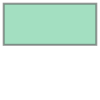

In [6]:
FOOTPRINT = polygon.to_crs('epsg:4326').geometry[0].envelope
FOOTPRINT

In [7]:
FOOTPRINT.bounds

(-124.6577454, 53.712152, -123.3847046, 54.2772531)

### 2.2 Set up the STAC Client

In [8]:
# Set up Stac Client
api = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
api

ID: microsoft-pc
Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer
type: Catalog
"conformsTo: ['http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/core', 'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/geojson', 'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/oas30', 'https://api.stacspec.org/v1.0.0-rc.1/collections', 'https://api.stacspec.org/v1.0.0-rc.1/core', 'https://api.stacspec.org/v1.0.0-rc.1/item-search', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#fields', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:basic-cql', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:cql-json', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:cql-text', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:filter', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:item-search-filter', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#query', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#sort', 'https://api.stacspec.org/v1.0.0-rc.1/ogcapi-features']"
ID: daymet-annual-pr
Title: Daymet Annual Puerto Rico
"Description: Annual climate summaries derived from [Daymet](https://daymet.ornl.gov) Version 4 daily data at a 1 km x 1 km spatial resolution for five variables: minimum and maximum temperature, precipitation, vapor pressure, and snow water equivalent. Annual averages are provided for minimum and maximum temperature, vapor pressure, and snow water equivalent, and annual totals are provided for the precipitation variable. [Daymet](https://daymet.ornl.gov/) provides measurements of near-surface meteorological conditions; the main purpose is to provide data estimates where no instrumentation exists. The dataset covers the period from January 1, 1980 to the present. Each year is processed individually at the close of a calendar year. Data are in a Lambert conformal conic projection for North America and are distributed in Zarr and NetCDF formats, compliant with the [Climate and Forecast (CF) metadata conventions (version 1.6)](http://cfconventions.org/). Use the DOI at [https://doi.org/10.3334/ORNLDAAC/1852](https://doi.org/10.3334/ORNLDAAC/1852) to cite your usage of the data. This dataset provides coverage for Hawaii; North America and Puerto Rico are provided in [separate datasets](https://planetarycomputer.microsoft.com/dataset/group/daymet#annual)."
"Providers: Microsoft (host, processor) ORNL DAAC (producer)"
type: Collection
title: Daymet Annual Puerto Rico


### 2.3 Query the STAC API for MODIS data, convert the STAC Query to an XArray.DataArray, and calculate the NDSI

In [9]:
# CONFIG 
# -------------
TGT_BANDS =  ['sur_refl_b01','sur_refl_b02','sur_refl_b03','sur_refl_b04','sur_refl_b05','sur_refl_b06','sur_refl_b07']

YEARS = ['2016','2017','2018','2019','2020','2021']
BEGIN_MONTH = '10'
END_MONTH = '03'
date_range = [f'2016-{BEGIN_MONTH}-01/2017-{END_MONTH}-30',f'2017-{BEGIN_MONTH}-01/2018-{END_MONTH}-30',f'2018-{BEGIN_MONTH}-01/2019-{END_MONTH}-30',
              f'2019-{BEGIN_MONTH}-01/2020-{END_MONTH}-30',f'2020-{BEGIN_MONTH}-01/2021-{END_MONTH}-30']
MAX_CLOUD = 25
READ_IN_CHUNK = 4096
RESOLUTION = 500
TEMPORAL_CHUNK = {'time': -1, 'band': 1, 'x': 128, 'y': 128}
SYNCHRONOUS = False # Write bands out one at a time - use if resources can't handle all bands at once for AOI
# -------------

**Create a function to calculate the NDSI from the Green and SWIR bands of the data.**

In [30]:
def get_NDSI(green, swir):
    # Compute the NDSI and return the resulting array into an Xarray DataArray
    NDSI = (green - swir) / (green + swir)
    NDSI_da = xr.DataArray(NDSI, dims=['y','x'])

    return NDSI_da

**Create a function that normalizes the data**

In [31]:
def normalize(array):
    norm = (array - array.min()) / (array.max() - array.min())
    return norm

**The cell below loops per Winter period and can be divided into three main sections:**

1. The API Query for the MOD09A1 data and signing of the data links for the results
2. The Converstion of the Query into an XArray.DataArray
3. The calculation of NDSI images and their concatenation into Winter Season time periods

In [32]:
item_dict = []
final_list = []
for period in date_range:
    
    # Query the Planetary Computer STAC server with pystac_client
    print(f'[Querying] {period}')
    items = api.search(
        collections = ['modis-09A1-061'],
        intersects = FOOTPRINT,
        datetime = period,
    ).get_all_items()
    
    # Sign the data links
    print(f'\tFound {len(items)} items')
    print('\t[Signing data links]')
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]
    item_dict+=signed_items
    clear_output(wait=True)
   
    # Convert STAC query into a xarray.DataArray
    print('\t[Converting STAC query to DataArray]')
    data = (
        stackstac.stack(
            item_dict,
            assets=TGT_BANDS, 
            chunksize=READ_IN_CHUNK, # Set chunksize
            resolution=RESOLUTION, # Set all bands res to this
            bounds_latlon=FOOTPRINT.bounds, # clip to AOI bounds
            epsg = 3153
        ).where(lambda x: x > 0, other=np.nan).assign_coords( # Convert nodata zero to np.nan
            band=lambda x: x.common_name.rename("band"),  # use common names
            time=lambda x: x.time.dt.round(
                "D"
            ))  
    )
    
    # Calculate the NDSI and concatenate into Winter Season images
    normalized = normalize(data)
    NDSI_aggs = [get_NDSI(x.sel(band='green'), x.sel(band='swir16')) for x in normalized]
    final_ndsi = xr.concat(NDSI_aggs, dim='start_datetime')
    final_ndsi = final_ndsi.mean(dim='start_datetime')
    final_ndsi.name = period
    final_list.append(final_ndsi)

# Concatenate the yearly Season images into the same DataArray and rename them all for better visualization.
final_arr = xr.concat(final_list, dim='start_datetime')
final_dat = final_arr.to_dataset('start_datetime')
final_dat = final_dat.rename({0:'Winter 2016', 1:'Winter 2017', 2:'Winter 2018', 3:'Winter 2019', 4:'Winter 2020'})
finalized_arr = final_dat.to_array('start_datetime')
print(finalized_arr)
print('Done')

	[Converting STAC query to DataArray]
<xarray.DataArray (start_datetime: 5, y: 132, x: 171)>
dask.array<stack, shape=(5, 132, 171), dtype=float64, chunksize=(1, 132, 171), chunktype=numpy.ndarray>
Coordinates:
    time                 datetime64[ns] NaT
  * x                    (x) float64 1.087e+06 1.088e+06 ... 1.172e+06 1.172e+06
  * y                    (y) float64 1.034e+06 1.034e+06 ... 9.69e+05 9.685e+05
    modis:vertical-tile  int64 3
    proj:epsg            object None
    proj:wkt2            <U424 'PROJCS["unnamed",GEOGCS["Unknown datum based ...
    proj:shape           object {2400}
    instruments          <U5 'modis'
    raster:bands         object {'scale': 0.0001, 'data_type': 'int16', 'spat...
    epsg                 int64 3153
  * start_datetime       (start_datetime) object 'Winter 2016' ... 'Winter 2020'
Done


**Compute the data**

In [33]:
final_ndsi_c = finalized_arr.persist().compute()

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.9/ssl.py", line 1310, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1129)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle

**Visualize the results!**

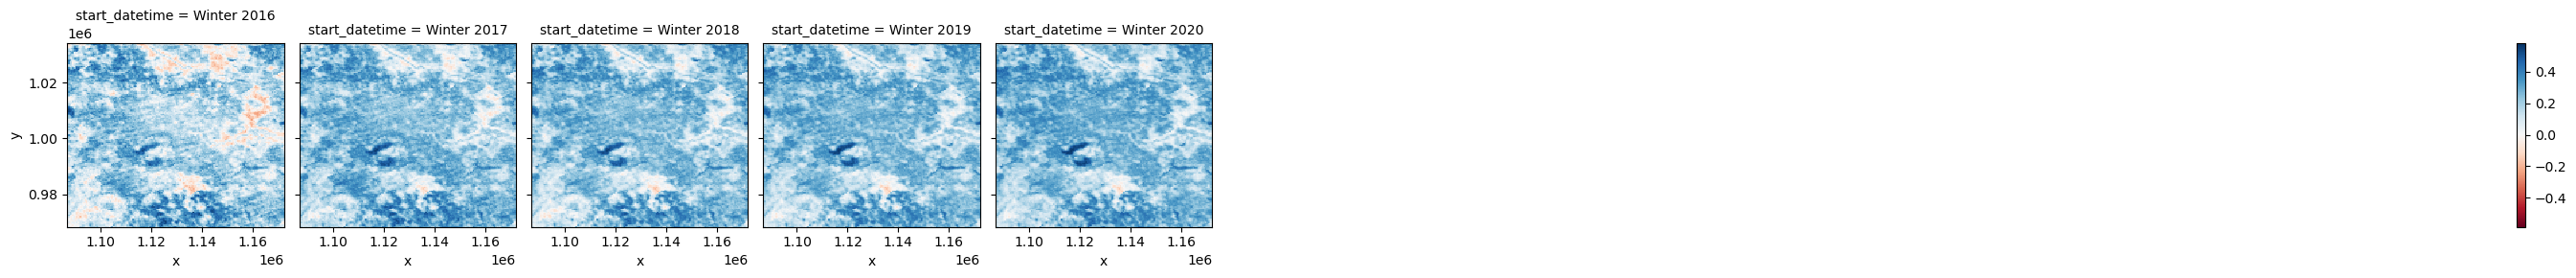

In [20]:
final_ndsi_c.plot.imshow(x="x", y="y", col="start_datetime", col_wrap=10, cmap="RdBu")

***Make sure to always explicitly shut down computing resources when you're not using them!***

In [143]:
cluster.close()